In [1]:
%pylab inline
import pandas as pd
import sys
import gc
import os
import lightgbm as lgb

Populating the interactive namespace from numpy and matplotlib


In [2]:
FOLD=int(os.getenv("FOLD"))

In [3]:
print FOLD

1


In [4]:
sys.path.insert(0,"../python/rrvf2017/")

In [5]:
from rrvf_data import   DataGen, normalize
import rrvf_data

In [6]:
def get_index(cols,columns):
    lst=[]
    for c in cols:
        lst.append(np.where(columns==c)[0][0])
    return np.array(lst)

In [7]:
def read_data(offset):
    columns,data=rrvf_data.read_data( offset,"../input/train_test_extb.npy.npz")
    rawy=data[:,:,get_index(['visitors'],columns)[0]].copy()
    print len(columns),data.shape,rawy.shape    
    return columns,data,rawy

In [8]:
gc.collect()

7

# cv

In [9]:
from sklearn.linear_model import Ridge

In [10]:
n_reg_lookback=7
n_lookforward=1
n_offset=0

In [11]:
lag_cols=['weekday6', 'weekday5', 'weekday4', 'weekday3', 'weekday2', 'weekday1', 'weekday0', 'const_one', 'visitors', 'geo1_visitors_mean', 'geo2_visitors_mean', 'station_visitors_mean', 'genre_name_visitors_mean', 'day_of_week_visitors_mean', 'visitor_lag7', 'visitor_lag14', 'visitor_lag28', 'visitor_lag91', 'visitor_lag182', 'visitor_lag364', 'visitor_ma2', 'visitor_ma4', 'visitor_ma7', 'visitor_ma14', 'visitor_ma28', 'visitor_ma56', 'visitor_ma112', 'visitor_ma224', 'visitor_sma1', 'visitor_sma2', 'visitor_sma3', 'visitor_sma4', 'visitor_sma8', 'visitor_sma16', 'visitor_sma32', 'visitors_minus_ma28', 'visitors_divid_ma28', 'all_count_y1', 'geo1_count_y1', 'station_count_y1', 'geo2_count_y1', 'all_count_y2', 'geo1_count_y2', 'station_count_y2', 'geo2_count_y2', 'all_count_y3', 'geo1_count_y3', 'station_count_y3', 'geo2_count_y3', 'all_count_y4', 'geo1_count_y4', 'station_count_y4', 'geo2_count_y4', 'all_count_y5', 'geo1_count_y5', 'station_count_y5', 'geo2_count_y5', 'TMAX', 'TMIN', 'TAVG', 'PRCP', 'holiday', 's16_y_nan', 's16_y_std', 's16_y1_ratio', 's16_y2_ratio', 'f_t', 'bad_ratio', 'rv_sum', 'rv_mean', 'rv_gap_mean', 'rv_gap_weighted_mean']
len(lag_cols)

72

In [12]:
def make_ondate_train_test(ondate_cols,data,columns):
    ondate_train_test=np.round(data[:,:,get_index(ondate_cols,columns)].copy(),2)
    ondate_train_test=normalize(ondate_train_test)
    v=np.zeros_like(ondate_train_test[:,:,0])
    for i in range(v.shape[0]): v[i]=i
    #ondate_train_test = np.concatenate([np.expand_dims(v,-1),ondate_train_test],axis=-1)
    print ondate_train_test.shape
    return ondate_train_test

In [13]:
ondate_cols =array(['const_one', 'visitor_lag91', 'visitor_lag182', 'TMIN', 'holiday', 'TAVG','f_t',
                    'weekday6', 'weekday5', 'weekday4', 'weekday3', 'weekday2', 'weekday1', 'weekday0',
                    'rv_sum', 'rv_mean', 'rv_gap_mean', 'rv_gap_weighted_mean'
                   ])

In [14]:
def make_lag_train_test(lag_cols,data,columns):
    lag_train_test=data[:,:,get_index(lag_cols,columns)].copy()
    #lag_train_test=normalize(lag_train_test)
    print lag_train_test.shape
    return lag_train_test

In [15]:
from sklearn.model_selection import GridSearchCV,ParameterGrid,ParameterSampler
from sklearn.metrics import  make_scorer
from multiprocessing import Pool

# time split

In [16]:
import cPickle as pickle
indexes=rrvf_data.get_train_valid_indexes()

In [17]:
def make_Xy(data_from_gen):
    print data_from_gen[0]['ondatex'].shape,data_from_gen[0]['lagx'].shape,data_from_gen[0]['masky'].shape,data_from_gen[1].shape
    X=np.concatenate([data_from_gen[0]['ondatex'].reshape([data_from_gen[0]['ondatex'].shape[0],-1]),
                    data_from_gen[0]['lagx'].reshape([data_from_gen[0]['lagx'].shape[0],-1])],axis=1)
    y=np.squeeze(data_from_gen[1])
    mask=np.squeeze(data_from_gen[0]['masky'].reshape([data_from_gen[0]['masky'].shape[0],-1]))
    print X.shape,y.shape,mask.shape
    mask= (mask>0) & (y>0)
    X=X[mask]
    X=np.concatenate([X,np.isnan(X)],axis=1).astype(np.float32)
    X[np.isnan(X)]=0    
    y=y[mask]
    dataidx=data_from_gen[3][mask]
    assert X.shape[0]==y.shape[0]
    return X,y,dataidx

In [18]:
from sklearn.metrics import mean_squared_error
def make_model(i, trainX,trainy, validX,validy, colsample_bytree=1,num_leaves=31,subsample=1,
               learning_rate=0.03,max_bin=127,
               min_data_in_leaf=20,lambda_l2=0,
               min_sum_hessian_in_leaf=1e-3, C=0.001,
               objective='binary' ):
        models=[]
        scores=[]
        gbm = Ridge()
        gbm.fit(trainX,trainy)

        models.append(gbm)
        validpred=gbm.predict(validX)
        scores.append(mean_squared_error(validy,validpred))
        print mean_squared_error(trainy,gbm.predict(trainX)), scores[-1]
        print scores
        print i, "mean score", np.mean(scores)
        return models[0],np.mean(scores),validpred
        #return np.mean(scores) 

In [19]:
def f(iparam,trainX,trainy,validX,validy):
    i,param=iparam
    return make_model(i,trainX,trainy,validX,validy, **param)

In [20]:
import rrvf_data
def g(model,testX,testy,testidx,n_offset):
    test_pred=model.predict(testX)    
    df=pd.DataFrame({'y':testy})
    df['pred']=test_pred
    df['dayidx']=testidx[:,1]+n_offset
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    print df2['error2'].mean()
    display(df2)
    return  df2['error2'].mean()

def g2(model,train_gen,offset):
    predlist=[]
    ylist=[]
    daylist=[]
    for i in range(7):
        i=478-7+i-offset
        Xdict,y,dataidx,_=train_gen.get_by_t2(day=i)
        X=np.concatenate([Xdict['ondatex'].reshape([Xdict['ondatex'].shape[0],-1]),
                    Xdict['lagx'].reshape([Xdict['lagx'].shape[0],-1])],axis=1)
        X=np.concatenate([X,np.isnan(X)],1)
        X[np.isnan(X)]=0        
        pred=model.predict(X).reshape(-1)
        predlist.append(pred)
        daylist.append(np.zeros_like(pred,dtype=int)+i+offset)
        ylist.append(y.reshape(-1))
    ylist=np.concatenate(ylist)
    predlist=np.concatenate(predlist)
    daylist=np.concatenate(daylist)
    df=pd.DataFrame({'y':ylist,'dayidx':daylist,'pred':predlist})
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    print df2['error2'].mean()
    display(df2)
    return  df2['error2'].mean()

PRED_DATE=478
def h(model,train_gen):
    Xdict,_,dataidx,_=train_gen.get_by_t2(day=PRED_DATE)
    X=np.concatenate([Xdict['ondatex'].reshape([Xdict['ondatex'].shape[0],-1]),
                    Xdict['lagx'].reshape([Xdict['lagx'].shape[0],-1])],axis=1)
    X=np.concatenate([X,np.isnan(X)],axis=1).astype(np.float32)
    X[np.isnan(X)]=0    
    #mask=np.squeeze(Xdict['masky'].reshape([Xdict.shape[0],-1]))
    print X.shape
    pred=model.predict(X)
    return pred,dataidx


In [21]:
parameter={'colsample_bytree': 0.5,
 'lambda_l2': 1,
 'learning_rate': 0.05,
 'max_bin': 255,
 'min_data_in_leaf': 30,
 'min_sum_hessian_in_leaf': 0.001,
 'num_leaves': 127,
 'objective': 'regression',
 'subsample': 0.8}

In [22]:
EXCLUDE_HARD=True
def _run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    assert n_offset+1==n_lookforward
    batchsize=128
    ondate_train_test=make_ondate_train_test(ondate_cols,data,columns)
    lag_train_test = make_lag_train_test(lag_cols,data,columns)
    train_gen=rrvf_data.DataGen(lag_train_test,ondate_train_test, rawy,n_reg_lookback+1, 478,#478-1*7-39-n_offset, 
                      batchsize=batchsize,valid_split=0.1, indexes=index,lookforward_offset=n_offset,
                      exclude_hard=EXCLUDE_HARD,
                  lookback1=n_reg_lookback,  lookforward=n_lookforward, excluded_days=None)
    valid_gen=None
    test_gen=rrvf_data.DataGen(lag_train_test,ondate_train_test, rawy,478-1*7-n_offset,478, lookforward_offset=n_offset,
                     batchsize=batchsize,lookback1=n_reg_lookback, lookforward=n_lookforward)
    print train_gen.train_steps_per_epoch
    print 0 if valid_gen is None else valid_gen.train_steps_per_epoch
    
    train_data_from_gen=train_gen.get_train()
    trainX,trainy,_=make_Xy(train_data_from_gen)
    valid_data_from_gen=train_gen.get_valid()
    validX,validy,valididx=make_Xy(valid_data_from_gen)
    test_data_from_gen=test_gen.get_train()
    testX,testy,testidx=make_Xy(test_data_from_gen)

    model,score,validpred=f((-1,parameter),trainX,trainy,validX,validy)
    g(model,testX,testy,testidx,n_offset)
    g2(model,train_gen,n_offset)
    
    pred478=h(model,train_gen)
    return score,(validy,valididx,validpred),pred478

def run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    return _run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset)        

In [23]:
def MSE(a,b):
    idx= np.isnan(a) | np.isnan(b)
    a=a[~idx]
    b=b[~idx]
    #print np.mean(~idx)
    return np.mean((a-b)**2)
    return mean_squared_error(a,b)

In [24]:
j=FOLD
validpreds={}
for offset in range(1,40):
    print "\n\n",offset
    columns,data,rawy=read_data(offset=offset)
    _,validpred,pred478=run_once(columns,data,rawy, indexes[j],ondate_cols,lag_cols,n_lookforward=offset,n_offset=offset-1)
    validpreds[offset]=[validpred,pred478]
    pickle.dump(validpreds, open('3000eb_ridge_fold{}_{}_d{}.pkl'.format(j, EXCLUDE_HARD, PRED_DATE),'wb'))



1


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 14.8043


(829, 517, 18)


(829, 517, 72)


train/valid # (311610, 2) (78020, 2)


train/valid # (201819, 2) (48921, 2)


train/valid # (164168, 2) (39785, 2)


rand split across time
train has 164168 records out of 389630 records
valid has 39785 records out of 389630 records
train has 5803 records out of 5803 records
no valid set
1282
0


(164168, 1, 18) (164168, 7, 72) (164168, 1) (164168, 1)
(164168, 522) (164168,) (164168,)


(48921, 1, 18) (48921, 7, 72) (48921, 1) (48921, 1)
(48921, 522) (48921,) (48921,)


(5803, 1, 18) (5803, 7, 72) (5803, 1) (5803, 1)
(5803, 522) (5803,) (5803,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.54814485484e-11 / 5.96046447754e-08
  RuntimeWarning)


0.0952596 0.279406
[0.27940622]
-1 mean score 0.279406


0.238864


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.971880 -0.042771  0.271206    7  2017-04-16
472     2.507290  2.584590 -0.077299  0.266138    1  2017-04-17
473     2.661330  2.667764 -0.006434  0.284333    2  2017-04-18
474     2.754815  2.770459 -0.015644  0.228876    3  2017-04-19
475     2.713762  2.757848 -0.044086  0.252962    4  2017-04-20
476     2.999000  2.999016 -0.000016  0.164686    5  2017-04-21
477     3.075529  3.108877 -0.033347  0.203843    6  2017-04-22

0.238864


pred         y     error    error2  day        date
dayidx                                                         
471     2.971880  2.929110 -0.042771  0.271206    7  2017-04-16
472     2.584590  2.507290 -0.077299  0.266138    1  2017-04-17
473     2.667764  2.661330 -0.006434  0.284333    2  2017-04-18
474     2.770459  2.754815 -0.015644  0.228876    3  2017-04-19
475     2.757848  2.713762 -0.044086  0.252962    4  2017-04-20
476     2.999016  2.999000 -0.000016  0.164686    5  2017-04-21
477     3.108877  3.075529 -0.033347  0.203843    6  2017-04-22

(829, 1044)




2


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 14.8043


(829, 517, 18)


(829, 517, 72)


train/valid # (311610, 2) (78020, 2)


train/valid # (201819, 2) (48921, 2)


train/valid # (169559, 2) (41029, 2)


rand split across time
train has 169559 records out of 389630 records
valid has 41029 records out of 389630 records
train has 6632 records out of 6632 records
no valid set
1324
0


(169559, 1, 18) (169559, 7, 72) (169559, 1) (169559, 1)


(169559, 522) (169559,) (169559,)


(48921, 1, 18) (48921, 7, 72) (48921, 1) (48921, 1)
(48921, 522) (48921,) (48921,)


(6632, 1, 18) (6632, 7, 72) (6632, 1) (6632, 1)
(6632, 522) (6632,) (6632,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 4.76128789173e-11 / 5.96046447754e-08
  RuntimeWarning)


0.0974806 0.275628
[0.27562779]
-1 mean score 0.275628
0.2395


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.952617 -0.023507  0.270741    7  2017-04-16
472     2.507290  2.588903 -0.081613  0.265090    1  2017-04-17
473     2.661330  2.687879 -0.026549  0.284053    2  2017-04-18
474     2.754815  2.777631 -0.022816  0.233210    3  2017-04-19
475     2.713762  2.764598 -0.050836  0.254253    4  2017-04-20
476     2.999000  3.017893 -0.018893  0.168433    5  2017-04-21
477     3.075529  3.080735 -0.005206  0.200717    6  2017-04-22

0.2395


pred         y     error    error2  day        date
dayidx                                                         
471     2.952617  2.929110 -0.023507  0.270741    7  2017-04-16
472     2.588903  2.507290 -0.081613  0.265090    1  2017-04-17
473     2.687879  2.661330 -0.026549  0.284053    2  2017-04-18
474     2.777631  2.754815 -0.022816  0.233210    3  2017-04-19
475     2.764598  2.713762 -0.050836  0.254253    4  2017-04-20
476     3.017893  2.999000 -0.018893  0.168433    5  2017-04-21
477     3.080735  3.075529 -0.005206  0.200717    6  2017-04-22

(829, 1044)




3


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 14.8043


(829, 517, 18)


(829, 517, 72)


train/valid # (311610, 2) (78020, 2)


train/valid # (201819, 2) (48921, 2)


train/valid # (170015, 2) (41155, 2)


rand split across time
train has 170015 records out of 389630 records
valid has 41155 records out of 389630 records
train has 7461 records out of 7461 records
no valid set
1328
0


(170015, 1, 18) (170015, 7, 72) (170015, 1) (170015, 1)


(170015, 522) (170015,) (170015,)


(48921, 1, 18) (48921, 7, 72) (48921, 1) (48921, 1)
(48921, 522) (48921,) (48921,)


(7461, 1, 18) (7461, 7, 72) (7461, 1) (7461, 1)
(7461, 522) (7461,) (7461,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.62782400007e-11 / 5.96046447754e-08
  RuntimeWarning)


0.0991736 0.27795
[0.27795011]
-1 mean score 0.27795
0.240668


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.945707 -0.016597  0.270986    7  2017-04-16
472     2.507290  2.589579 -0.082288  0.265527    1  2017-04-17
473     2.661330  2.672793 -0.011463  0.286002    2  2017-04-18
474     2.754815  2.784821 -0.030006  0.233888    3  2017-04-19
475     2.713762  2.761851 -0.048089  0.257732    4  2017-04-20
476     2.999000  3.012687 -0.013688  0.169974    5  2017-04-21
477     3.075529  3.095010 -0.019480  0.200570    6  2017-04-22

0.240668


pred         y     error    error2  day        date
dayidx                                                         
471     2.945707  2.929110 -0.016597  0.270986    7  2017-04-16
472     2.589579  2.507290 -0.082288  0.265527    1  2017-04-17
473     2.672793  2.661330 -0.011463  0.286002    2  2017-04-18
474     2.784821  2.754815 -0.030006  0.233888    3  2017-04-19
475     2.761851  2.713762 -0.048089  0.257732    4  2017-04-20
476     3.012687  2.999000 -0.013688  0.169974    5  2017-04-21
477     3.095010  3.075529 -0.019480  0.200570    6  2017-04-22

(829, 1044)




4


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 14.8043


(829, 517, 18)


(829, 517, 72)


train/valid # (311610, 2) (78020, 2)


train/valid # (201819, 2) (48921, 2)


train/valid # (170110, 2) (41185, 2)


rand split across time
train has 170110 records out of 389630 records
valid has 41185 records out of 389630 records
train has 8290 records out of 8290 records
no valid set
1328
0


(170110, 1, 18) (170110, 7, 72) (170110, 1) (170110, 1)


(170110, 522) (170110,) (170110,)


(48921, 1, 18) (48921, 7, 72) (48921, 1) (48921, 1)
(48921, 522) (48921,) (48921,)


(8290, 1, 18) (8290, 7, 72) (8290, 1) (8290, 1)
(8290, 522) (8290,) (8290,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 4.05905517531e-11 / 5.96046447754e-08
  RuntimeWarning)


0.100157 0.278357
[0.27835745]
-1 mean score 0.278357
0.241989


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.932354 -0.003245  0.271385    7  2017-04-16
472     2.507290  2.602432 -0.095141  0.268445    1  2017-04-17
473     2.661330  2.659103  0.002227  0.287319    2  2017-04-18
474     2.754815  2.772614 -0.017800  0.233026    3  2017-04-19
475     2.713762  2.759435 -0.045673  0.261723    4  2017-04-20
476     2.999000  2.980892  0.018108  0.171705    5  2017-04-21
477     3.075529  3.093325 -0.017796  0.200322    6  2017-04-22

0.241989


pred         y     error    error2  day        date
dayidx                                                         
471     2.932354  2.929110 -0.003245  0.271385    7  2017-04-16
472     2.602432  2.507290 -0.095141  0.268445    1  2017-04-17
473     2.659103  2.661330  0.002227  0.287319    2  2017-04-18
474     2.772614  2.754815 -0.017800  0.233026    3  2017-04-19
475     2.759435  2.713762 -0.045673  0.261723    4  2017-04-20
476     2.980892  2.999000  0.018108  0.171705    5  2017-04-21
477     3.093325  3.075529 -0.017796  0.200322    6  2017-04-22

(829, 1044)




5


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 14.8043


(829, 517, 18)


(829, 517, 72)


train/valid # (311610, 2) (78020, 2)


train/valid # (201819, 2) (48921, 2)


train/valid # (170302, 2) (41190, 2)


rand split across time
train has 170302 records out of 389630 records
valid has 41190 records out of 389630 records
train has 9119 records out of 9119 records
no valid set
1330
0


(170302, 1, 18) (170302, 7, 72) (170302, 1) (170302, 1)
(170302, 522) (170302,) (170302,)


(48921, 1, 18) (48921, 7, 72) (48921, 1) (48921, 1)
(48921, 522) (48921,) (48921,)


(9119, 1, 18) (9119, 7, 72) (9119, 1) (9119, 1)
(9119, 522) (9119,) (9119,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 5.07204243883e-11 / 5.96046447754e-08
  RuntimeWarning)


0.100835 0.279616
[0.27961573]
-1 mean score 0.279616
0.242484


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.949376 -0.020266  0.272572    7  2017-04-16
472     2.507290  2.596906 -0.089615  0.268469    1  2017-04-17
473     2.661330  2.663694 -0.002364  0.287515    2  2017-04-18
474     2.754815  2.760250 -0.005435  0.232928    3  2017-04-19
475     2.713762  2.751858 -0.038097  0.261062    4  2017-04-20
476     2.999000  2.983603  0.015397  0.172816    5  2017-04-21
477     3.075529  3.076657 -0.001127  0.202027    6  2017-04-22

0.242484


pred         y     error    error2  day        date
dayidx                                                         
471     2.949376  2.929110 -0.020266  0.272572    7  2017-04-16
472     2.596906  2.507290 -0.089615  0.268469    1  2017-04-17
473     2.663694  2.661330 -0.002364  0.287515    2  2017-04-18
474     2.760250  2.754815 -0.005435  0.232928    3  2017-04-19
475     2.751858  2.713762 -0.038097  0.261062    4  2017-04-20
476     2.983603  2.999000  0.015397  0.172816    5  2017-04-21
477     3.076657  3.075529 -0.001127  0.202027    6  2017-04-22

(829, 1044)




6


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 15.1334


(829, 517, 18)


(829, 517, 72)


train/valid # (311610, 2) (78020, 2)


train/valid # (201819, 2) (48921, 2)


train/valid # (170217, 2) (41200, 2)


rand split across time
train has 170217 records out of 389630 records
valid has 41200 records out of 389630 records
train has 9948 records out of 9948 records
no valid set
1329
0


(170217, 1, 18) (170217, 7, 72) (170217, 1) (170217, 1)


(170217, 522) (170217,) (170217,)


(48921, 1, 18) (48921, 7, 72) (48921, 1) (48921, 1)
(48921, 522) (48921,) (48921,)


(9948, 1, 18) (9948, 7, 72) (9948, 1) (9948, 1)
(9948, 522) (9948,) (9948,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 6.38916905493e-11 / 5.96046447754e-08
  RuntimeWarning)


0.101729 0.279841
[0.27984121]
-1 mean score 0.279841
0.243604


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.945914 -0.016804  0.271759    7  2017-04-16
472     2.507290  2.604357 -0.097067  0.270626    1  2017-04-17
473     2.661330  2.660112  0.001217  0.289877    2  2017-04-18
474     2.754815  2.757905 -0.003090  0.232423    3  2017-04-19
475     2.713762  2.749886 -0.036124  0.261742    4  2017-04-20
476     2.999000  2.966298  0.032702  0.174801    5  2017-04-21
477     3.075529  3.098484 -0.022955  0.203998    6  2017-04-22

0.243604


pred         y     error    error2  day        date
dayidx                                                         
471     2.945914  2.929110 -0.016804  0.271759    7  2017-04-16
472     2.604357  2.507290 -0.097067  0.270626    1  2017-04-17
473     2.660112  2.661330  0.001217  0.289877    2  2017-04-18
474     2.757905  2.754815 -0.003090  0.232423    3  2017-04-19
475     2.749886  2.713762 -0.036124  0.261742    4  2017-04-20
476     2.966298  2.999000  0.032702  0.174801    5  2017-04-21
477     3.098484  3.075529 -0.022955  0.203998    6  2017-04-22

(829, 1044)




7


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 16.3101


(829, 517, 18)


(829, 517, 72)


train/valid # (311610, 2) (78020, 2)


train/valid # (201819, 2) (48921, 2)


train/valid # (170577, 2) (41308, 2)


rand split across time
train has 170577 records out of 389630 records
valid has 41308 records out of 389630 records
train has 10777 records out of 10777 records
no valid set
1332
0


(170577, 1, 18) (170577, 7, 72) (170577, 1) (170577, 1)
(170577, 522) (170577,) (170577,)


(48921, 1, 18) (48921, 7, 72) (48921, 1) (48921, 1)
(48921, 522) (48921,) (48921,)


(10777, 1, 18) (10777, 7, 72) (10777, 1) (10777, 1)
(10777, 522) (10777,) (10777,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 9.65983265599e-11 / 5.96046447754e-08
  RuntimeWarning)


0.102672 0.276208
[0.27620831]
-1 mean score 0.276208
0.244459


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.949847 -0.020737  0.271285    7  2017-04-16
472     2.507290  2.616431 -0.109140  0.277476    1  2017-04-17
473     2.661330  2.672090 -0.010760  0.293938    2  2017-04-18
474     2.754815  2.752196  0.002618  0.235853    3  2017-04-19
475     2.713762  2.750913 -0.037151  0.260459    4  2017-04-20
476     2.999000  2.979223  0.019777  0.173014    5  2017-04-21
477     3.075529  3.110080 -0.034551  0.199188    6  2017-04-22

0.244459


pred         y     error    error2  day        date
dayidx                                                         
471     2.949847  2.929110 -0.020737  0.271285    7  2017-04-16
472     2.616431  2.507290 -0.109140  0.277476    1  2017-04-17
473     2.672090  2.661330 -0.010760  0.293938    2  2017-04-18
474     2.752196  2.754815  0.002618  0.235853    3  2017-04-19
475     2.750913  2.713762 -0.037151  0.260459    4  2017-04-20
476     2.979223  2.999000  0.019777  0.173014    5  2017-04-21
477     3.110080  3.075529 -0.034551  0.199188    6  2017-04-22

(829, 1044)




8


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 17.5743


(829, 517, 18)


(829, 517, 72)


train/valid # (311610, 2) (78020, 2)


train/valid # (201819, 2) (48921, 2)


train/valid # (169934, 2) (41199, 2)


rand split across time
train has 169934 records out of 389630 records
valid has 41199 records out of 389630 records
train has 11606 records out of 11606 records
no valid set
1327
0


(169934, 1, 18) (169934, 7, 72) (169934, 1) (169934, 1)


(169934, 522) (169934,) (169934,)


(48921, 1, 18) (48921, 7, 72) (48921, 1) (48921, 1)
(48921, 522) (48921,) (48921,)


(11606, 1, 18) (11606, 7, 72) (11606, 1) (11606, 1)
(11606, 522) (11606,) (11606,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.75152470652e-12 / 5.96046447754e-08
  RuntimeWarning)


0.110661 0.275306
[0.27530569]
-1 mean score 0.275306
0.25278


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.967420 -0.038310  0.284461    7  2017-04-16
472     2.507290  2.621180 -0.113890  0.278755    1  2017-04-17
473     2.661330  2.698738 -0.037408  0.300773    2  2017-04-18
474     2.754815  2.770715 -0.015900  0.251520    3  2017-04-19
475     2.713762  2.747826 -0.034065  0.268576    4  2017-04-20
476     2.999000  2.998183  0.000817  0.182662    5  2017-04-21
477     3.075529  3.118099 -0.042570  0.202710    6  2017-04-22

0.25278


pred         y     error    error2  day        date
dayidx                                                         
471     2.967420  2.929110 -0.038310  0.284461    7  2017-04-16
472     2.621180  2.507290 -0.113890  0.278755    1  2017-04-17
473     2.698738  2.661330 -0.037408  0.300773    2  2017-04-18
474     2.770715  2.754815 -0.015900  0.251520    3  2017-04-19
475     2.747826  2.713762 -0.034065  0.268576    4  2017-04-20
476     2.998183  2.999000  0.000817  0.182662    5  2017-04-21
477     3.118099  3.075529 -0.042570  0.202710    6  2017-04-22

(829, 1044)




9


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 18.8065


(829, 517, 18)


(829, 517, 72)


train/valid # (311610, 2) (78020, 2)


train/valid # (201819, 2) (48921, 2)


train/valid # (171018, 2) (41357, 2)


rand split across time
train has 171018 records out of 389630 records
valid has 41357 records out of 389630 records
train has 12435 records out of 12435 records
no valid set
1336
0


(171018, 1, 18) (171018, 7, 72) (171018, 1) (171018, 1)


(171018, 522) (171018,) (171018,)


(48921, 1, 18) (48921, 7, 72) (48921, 1) (48921, 1)
(48921, 522) (48921,) (48921,)


(12435, 1, 18) (12435, 7, 72) (12435, 1) (12435, 1)
(12435, 522) (12435,) (12435,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 4.84339963969e-11 / 5.96046447754e-08
  RuntimeWarning)


0.111676 0.285517
[0.28551745]
-1 mean score 0.285517
0.252815


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.962164 -0.033054  0.282342    7  2017-04-16
472     2.507290  2.621164 -0.113874  0.278803    1  2017-04-17
473     2.661330  2.711172 -0.049842  0.307143    2  2017-04-18
474     2.754815  2.774012 -0.019197  0.249952    3  2017-04-19
475     2.713762  2.758931 -0.045170  0.268874    4  2017-04-20
476     2.999000  2.987591  0.011409  0.181814    5  2017-04-21
477     3.075529  3.105581 -0.030051  0.200778    6  2017-04-22

0.252815


pred         y     error    error2  day        date
dayidx                                                         
471     2.962164  2.929110 -0.033054  0.282342    7  2017-04-16
472     2.621165  2.507290 -0.113874  0.278803    1  2017-04-17
473     2.711172  2.661330 -0.049842  0.307143    2  2017-04-18
474     2.774012  2.754815 -0.019197  0.249952    3  2017-04-19
475     2.758931  2.713762 -0.045170  0.268874    4  2017-04-20
476     2.987591  2.999000  0.011409  0.181814    5  2017-04-21
477     3.105581  3.075529 -0.030051  0.200778    6  2017-04-22

(829, 1044)




10


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 19.9265


(829, 517, 18)


(829, 517, 72)


train/valid # (311610, 2) (78020, 2)


train/valid # (201819, 2) (48921, 2)


train/valid # (171123, 2) (41388, 2)


rand split across time
train has 171123 records out of 389630 records
valid has 41388 records out of 389630 records
train has 13264 records out of 13264 records
no valid set
1336
0


(171123, 1, 18) (171123, 7, 72) (171123, 1) (171123, 1)


(171123, 522) (171123,) (171123,)


(48921, 1, 18) (48921, 7, 72) (48921, 1) (48921, 1)
(48921, 522) (48921,) (48921,)


(13264, 1, 18) (13264, 7, 72) (13264, 1) (13264, 1)
(13264, 522) (13264,) (13264,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.48245390858e-11 / 5.96046447754e-08
  RuntimeWarning)


0.112434 0.289649
[0.28964916]
-1 mean score 0.289649
0.25315


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.965389 -0.036280  0.284666    7  2017-04-16
472     2.507290  2.624175 -0.116884  0.277850    1  2017-04-17
473     2.661330  2.705342 -0.044013  0.307677    2  2017-04-18
474     2.754815  2.767313 -0.012499  0.251572    3  2017-04-19
475     2.713762  2.760981 -0.047219  0.269973    4  2017-04-20
476     2.999000  3.002510 -0.003510  0.180880    5  2017-04-21
477     3.075529  3.089264 -0.013735  0.199429    6  2017-04-22

0.25315


pred         y     error    error2  day        date
dayidx                                                         
471     2.965389  2.929110 -0.036280  0.284666    7  2017-04-16
472     2.624175  2.507290 -0.116884  0.277850    1  2017-04-17
473     2.705342  2.661330 -0.044013  0.307677    2  2017-04-18
474     2.767313  2.754815 -0.012499  0.251572    3  2017-04-19
475     2.760981  2.713762 -0.047219  0.269973    4  2017-04-20
476     3.002510  2.999000 -0.003510  0.180880    5  2017-04-21
477     3.089264  3.075529 -0.013735  0.199429    6  2017-04-22

(829, 1044)




11


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 21.0577


(829, 517, 18)


(829, 517, 72)


train/valid # (311610, 2) (78020, 2)


train/valid # (201819, 2) (48921, 2)


train/valid # (171104, 2) (41361, 2)


rand split across time
train has 171104 records out of 389630 records
valid has 41361 records out of 389630 records
train has 14093 records out of 14093 records
no valid set
1336
0


(171104, 1, 18) (171104, 7, 72) (171104, 1) (171104, 1)


(171104, 522) (171104,) (171104,)


(48921, 1, 18) (48921, 7, 72) (48921, 1) (48921, 1)
(48921, 522) (48921,) (48921,)


(14093, 1, 18) (14093, 7, 72) (14093, 1) (14093, 1)
(14093, 522) (14093,) (14093,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.06817568679e-10 / 5.96046447754e-08
  RuntimeWarning)


0.11284 0.289755
[0.28975502]
-1 mean score 0.289755
0.252998


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.958694 -0.029584  0.283975    7  2017-04-16
472     2.507290  2.633097 -0.125807  0.280821    1  2017-04-17
473     2.661330  2.714286 -0.052956  0.307288    2  2017-04-18
474     2.754815  2.749295  0.005519  0.250180    3  2017-04-19
475     2.713762  2.754064 -0.040302  0.269869    4  2017-04-20
476     2.999000  3.005354 -0.006355  0.178420    5  2017-04-21
477     3.075529  3.105340 -0.029811  0.200435    6  2017-04-22

0.252998


pred         y     error    error2  day        date
dayidx                                                         
471     2.958694  2.929110 -0.029584  0.283975    7  2017-04-16
472     2.633097  2.507290 -0.125807  0.280821    1  2017-04-17
473     2.714286  2.661330 -0.052956  0.307288    2  2017-04-18
474     2.749295  2.754815  0.005519  0.250180    3  2017-04-19
475     2.754064  2.713762 -0.040302  0.269869    4  2017-04-20
476     3.005354  2.999000 -0.006355  0.178420    5  2017-04-21
477     3.105340  3.075529 -0.029811  0.200435    6  2017-04-22

(829, 1044)




12


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 22.1151


(829, 517, 18)


(829, 517, 72)


train/valid # (311610, 2) (78020, 2)


train/valid # (201819, 2) (48921, 2)


train/valid # (171118, 2) (41368, 2)


rand split across time
train has 171118 records out of 389630 records
valid has 41368 records out of 389630 records
train has 14922 records out of 14922 records
no valid set
1336
0


(171118, 1, 18) (171118, 7, 72) (171118, 1) (171118, 1)


(171118, 522) (171118,) (171118,)


(48921, 1, 18) (48921, 7, 72) (48921, 1) (48921, 1)
(48921, 522) (48921,) (48921,)


(14922, 1, 18) (14922, 7, 72) (14922, 1) (14922, 1)
(14922, 522) (14922,) (14922,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.73714982571e-11 / 5.96046447754e-08
  RuntimeWarning)


0.112665 0.291006
[0.29100567]
-1 mean score 0.291006
0.254082


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.968608 -0.039498  0.284291    7  2017-04-16
472     2.507290  2.638811 -0.131521  0.281791    1  2017-04-17
473     2.661330  2.722763 -0.061433  0.306372    2  2017-04-18
474     2.754815  2.764456 -0.009641  0.253080    3  2017-04-19
475     2.713762  2.748939 -0.035178  0.271177    4  2017-04-20
476     2.999000  2.995706  0.003293  0.180566    5  2017-04-21
477     3.075529  3.109378 -0.033849  0.201297    6  2017-04-22

0.254082


pred         y     error    error2  day        date
dayidx                                                         
471     2.968608  2.929110 -0.039498  0.284291    7  2017-04-16
472     2.638811  2.507290 -0.131521  0.281791    1  2017-04-17
473     2.722763  2.661330 -0.061433  0.306372    2  2017-04-18
474     2.764456  2.754815 -0.009641  0.253080    3  2017-04-19
475     2.748939  2.713762 -0.035178  0.271177    4  2017-04-20
476     2.995706  2.999000  0.003293  0.180566    5  2017-04-21
477     3.109378  3.075529 -0.033849  0.201297    6  2017-04-22

(829, 1044)




13


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 23.1552


(829, 517, 18)


(829, 517, 72)


train/valid # (311610, 2) (78020, 2)


train/valid # (201819, 2) (48921, 2)


train/valid # (171021, 2) (41388, 2)


rand split across time
train has 171021 records out of 389630 records
valid has 41388 records out of 389630 records
train has 15751 records out of 15751 records
no valid set
1336
0


(171021, 1, 18) (171021, 7, 72) (171021, 1) (171021, 1)


(171021, 522) (171021,) (171021,)


(48921, 1, 18) (48921, 7, 72) (48921, 1) (48921, 1)
(48921, 522) (48921,) (48921,)


(15751, 1, 18) (15751, 7, 72) (15751, 1) (15751, 1)
(15751, 522) (15751,) (15751,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 6.81378425904e-11 / 5.96046447754e-08
  RuntimeWarning)


0.113113 0.289645
[0.28964537]
-1 mean score 0.289645
0.254896


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.970085 -0.040975  0.289053    7  2017-04-16
472     2.507290  2.652808 -0.145517  0.285331    1  2017-04-17
473     2.661330  2.716525 -0.055195  0.305228    2  2017-04-18
474     2.754815  2.762613 -0.007798  0.252644    3  2017-04-19
475     2.713762  2.753911 -0.040149  0.270659    4  2017-04-20
476     2.999000  2.999845 -0.000845  0.180056    5  2017-04-21
477     3.075529  3.096317 -0.020787  0.201302    6  2017-04-22

0.254896


pred         y     error    error2  day        date
dayidx                                                         
471     2.970085  2.929110 -0.040975  0.289053    7  2017-04-16
472     2.652808  2.507290 -0.145517  0.285331    1  2017-04-17
473     2.716525  2.661330 -0.055195  0.305228    2  2017-04-18
474     2.762613  2.754815 -0.007798  0.252644    3  2017-04-19
475     2.753911  2.713762 -0.040149  0.270659    4  2017-04-20
476     2.999845  2.999000 -0.000845  0.180056    5  2017-04-21
477     3.096317  3.075529 -0.020787  0.201302    6  2017-04-22

(829, 1044)




14


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 24.2264


(829, 517, 18)


(829, 517, 72)


train/valid # (311610, 2) (78020, 2)


train/valid # (201819, 2) (48921, 2)


train/valid # (171207, 2) (41511, 2)


rand split across time
train has 171207 records out of 389630 records
valid has 41511 records out of 389630 records
train has 16580 records out of 16580 records
no valid set
1337
0


(171207, 1, 18) (171207, 7, 72) (171207, 1) (171207, 1)


(171207, 522) (171207,) (171207,)


(48921, 1, 18) (48921, 7, 72) (48921, 1) (48921, 1)
(48921, 522) (48921,) (48921,)


(16580, 1, 18) (16580, 7, 72) (16580, 1) (16580, 1)
(16580, 522) (16580,) (16580,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.2554367268e-10 / 5.96046447754e-08
  RuntimeWarning)


0.112589 0.283774
[0.28377372]
-1 mean score 0.283774
0.25705


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.977379 -0.048269  0.290164    7  2017-04-16
472     2.507290  2.647541 -0.140250  0.289318    1  2017-04-17
473     2.661330  2.724350 -0.063021  0.309101    2  2017-04-18
474     2.754815  2.757077 -0.002262  0.257374    3  2017-04-19
475     2.713762  2.749217 -0.035455  0.270405    4  2017-04-20
476     2.999000  3.014443 -0.015443  0.178259    5  2017-04-21
477     3.075529  3.101916 -0.026387  0.204729    6  2017-04-22

0.25705


pred         y     error    error2  day        date
dayidx                                                         
471     2.977379  2.929110 -0.048269  0.290164    7  2017-04-16
472     2.647541  2.507290 -0.140250  0.289318    1  2017-04-17
473     2.724350  2.661330 -0.063021  0.309101    2  2017-04-18
474     2.757077  2.754815 -0.002262  0.257374    3  2017-04-19
475     2.749217  2.713762 -0.035455  0.270405    4  2017-04-20
476     3.014443  2.999000 -0.015443  0.178259    5  2017-04-21
477     3.101916  3.075529 -0.026387  0.204729    6  2017-04-22

(829, 1044)




15


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 25.3577


(829, 517, 18)


(829, 517, 72)


train/valid # (311610, 2) (78020, 2)


train/valid # (201819, 2) (48921, 2)


train/valid # (170658, 2) (41344, 2)


rand split across time
train has 170658 records out of 389630 records
valid has 41344 records out of 389630 records
train has 17409 records out of 17409 records
no valid set
1333
0


(170658, 1, 18) (170658, 7, 72) (170658, 1) (170658, 1)


(170658, 522) (170658,) (170658,)


(48921, 1, 18) (48921, 7, 72) (48921, 1) (48921, 1)
(48921, 522) (48921,) (48921,)


(17409, 1, 18) (17409, 7, 72) (17409, 1) (17409, 1)
(17409, 522) (17409,) (17409,)


0.117314 0.28533
[0.28533021]
-1 mean score 0.28533
0.263828


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  3.008497 -0.079387  0.311821    7  2017-04-16
472     2.507290  2.651875 -0.144585  0.296513    1  2017-04-17
473     2.661330  2.741370 -0.080041  0.319314    2  2017-04-18
474     2.754815  2.758005 -0.003190  0.252788    3  2017-04-19
475     2.713762  2.750507 -0.036745  0.281260    4  2017-04-20
476     2.999000  3.002618 -0.003618  0.181309    5  2017-04-21
477     3.075529  3.091392 -0.015862  0.203791    6  2017-04-22

0.263828


pred         y     error    error2  day        date
dayidx                                                         
471     3.008497  2.929110 -0.079387  0.311821    7  2017-04-16
472     2.651875  2.507290 -0.144585  0.296513    1  2017-04-17
473     2.741370  2.661330 -0.080041  0.319314    2  2017-04-18
474     2.758005  2.754815 -0.003190  0.252788    3  2017-04-19
475     2.750507  2.713762 -0.036745  0.281260    4  2017-04-20
476     3.002618  2.999000 -0.003618  0.181309    5  2017-04-21
477     3.091392  3.075529 -0.015862  0.203791    6  2017-04-22

(829, 1044)




16


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 26.4659


(829, 517, 18)


(829, 517, 72)


train/valid # (311610, 2) (78020, 2)


train/valid # (201819, 2) (48921, 2)


train/valid # (171566, 2) (41510, 2)


rand split across time
train has 171566 records out of 389630 records
valid has 41510 records out of 389630 records
train has 18238 records out of 18238 records
no valid set
1340
0


(171566, 1, 18) (171566, 7, 72) (171566, 1) (171566, 1)


(171566, 522) (171566,) (171566,)


(48921, 1, 18) (48921, 7, 72) (48921, 1) (48921, 1)
(48921, 522) (48921,) (48921,)


(18238, 1, 18) (18238, 7, 72) (18238, 1) (18238, 1)
(18238, 522) (18238,) (18238,)


0.118525 0.293618
[0.2936177]
-1 mean score 0.293618
0.26597


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.987430 -0.058320  0.305514    7  2017-04-16
472     2.507290  2.666078 -0.158787  0.303943    1  2017-04-17
473     2.661330  2.744041 -0.082711  0.322090    2  2017-04-18
474     2.754815  2.764106 -0.009291  0.257101    3  2017-04-19
475     2.713762  2.766055 -0.052293  0.282602    4  2017-04-20
476     2.999000  2.993938  0.005061  0.185349    5  2017-04-21
477     3.075529  3.090252 -0.014723  0.205193    6  2017-04-22

0.26597


pred         y     error    error2  day        date
dayidx                                                         
471     2.987430  2.929110 -0.058320  0.305514    7  2017-04-16
472     2.666078  2.507290 -0.158787  0.303943    1  2017-04-17
473     2.744041  2.661330 -0.082711  0.322090    2  2017-04-18
474     2.764106  2.754815 -0.009291  0.257101    3  2017-04-19
475     2.766055  2.713762 -0.052293  0.282602    4  2017-04-20
476     2.993938  2.999000  0.005061  0.185349    5  2017-04-21
477     3.090252  3.075529 -0.014723  0.205193    6  2017-04-22

(829, 1044)




17


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 27.6058


(829, 517, 18)


(829, 517, 72)


train/valid # (311610, 2) (78020, 2)


train/valid # (201819, 2) (48921, 2)


train/valid # (171844, 2) (41581, 2)


rand split across time
train has 171844 records out of 389630 records
valid has 41581 records out of 389630 records
train has 19067 records out of 19067 records
no valid set
1342
0


(171844, 1, 18) (171844, 7, 72) (171844, 1) (171844, 1)


(171844, 522) (171844,) (171844,)


(48921, 1, 18) (48921, 7, 72) (48921, 1) (48921, 1)
(48921, 522) (48921,) (48921,)


(19067, 1, 18) (19067, 7, 72) (19067, 1) (19067, 1)
(19067, 522) (19067,) (19067,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 4.4266867949e-11 / 5.96046447754e-08
  RuntimeWarning)


0.119443 0.294715
[0.29471472]
-1 mean score 0.294715
0.265262


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.974280 -0.045170  0.302051    7  2017-04-16
472     2.507290  2.637405 -0.130115  0.296039    1  2017-04-17
473     2.661330  2.733392 -0.072062  0.321735    2  2017-04-18
474     2.754815  2.778258 -0.023443  0.259175    3  2017-04-19
475     2.713762  2.765727 -0.051966  0.285349    4  2017-04-20
476     2.999000  3.011955 -0.012955  0.186574    5  2017-04-21
477     3.075529  3.083482 -0.007952  0.205909    6  2017-04-22

0.265262


pred         y     error    error2  day        date
dayidx                                                         
471     2.974280  2.929110 -0.045170  0.302051    7  2017-04-16
472     2.637405  2.507290 -0.130115  0.296039    1  2017-04-17
473     2.733392  2.661330 -0.072062  0.321735    2  2017-04-18
474     2.778258  2.754815 -0.023443  0.259175    3  2017-04-19
475     2.765727  2.713762 -0.051966  0.285349    4  2017-04-20
476     3.011955  2.999000 -0.012955  0.186574    5  2017-04-21
477     3.083482  3.075529 -0.007952  0.205909    6  2017-04-22

(829, 1044)




18


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 28.7513


(829, 517, 18)


(829, 517, 72)


train/valid # (311610, 2) (78020, 2)


train/valid # (201819, 2) (48921, 2)


train/valid # (171808, 2) (41563, 2)


rand split across time
train has 171808 records out of 389630 records
valid has 41563 records out of 389630 records
train has 19896 records out of 19896 records
no valid set
1342
0


(171808, 1, 18) (171808, 7, 72) (171808, 1) (171808, 1)


(171808, 522) (171808,) (171808,)


(48921, 1, 18) (48921, 7, 72) (48921, 1) (48921, 1)
(48921, 522) (48921,) (48921,)


(19896, 1, 18) (19896, 7, 72) (19896, 1) (19896, 1)
(19896, 522) (19896,) (19896,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.18940985533e-11 / 5.96046447754e-08
  RuntimeWarning)


0.119544 0.294691
[0.29469141]
-1 mean score 0.294691
0.265672


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.984667 -0.055557  0.305517    7  2017-04-16
472     2.507290  2.637689 -0.130398  0.296110    1  2017-04-17
473     2.661330  2.722980 -0.061650  0.319964    2  2017-04-18
474     2.754815  2.764114 -0.009299  0.260902    3  2017-04-19
475     2.713762  2.755476 -0.041714  0.282925    4  2017-04-20
476     2.999000  3.013350 -0.014351  0.188266    5  2017-04-21
477     3.075529  3.087095 -0.011566  0.206022    6  2017-04-22

0.265672


pred         y     error    error2  day        date
dayidx                                                         
471     2.984667  2.929110 -0.055557  0.305517    7  2017-04-16
472     2.637689  2.507290 -0.130398  0.296110    1  2017-04-17
473     2.722980  2.661330 -0.061650  0.319964    2  2017-04-18
474     2.764114  2.754815 -0.009299  0.260902    3  2017-04-19
475     2.755476  2.713762 -0.041714  0.282925    4  2017-04-20
476     3.013350  2.999000 -0.014351  0.188266    5  2017-04-21
477     3.087095  3.075529 -0.011566  0.206022    6  2017-04-22

(829, 1044)




19


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 29.7986


(829, 517, 18)


(829, 517, 72)


train/valid # (311610, 2) (78020, 2)


train/valid # (201819, 2) (48921, 2)


train/valid # (171953, 2) (41543, 2)


rand split across time
train has 171953 records out of 389630 records
valid has 41543 records out of 389630 records
train has 20725 records out of 20725 records
no valid set
1343
0


(171953, 1, 18) (171953, 7, 72) (171953, 1) (171953, 1)


(171953, 522) (171953,) (171953,)


(48921, 1, 18) (48921, 7, 72) (48921, 1) (48921, 1)
(48921, 522) (48921,) (48921,)


(20725, 1, 18) (20725, 7, 72) (20725, 1) (20725, 1)
(20725, 522) (20725,) (20725,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 5.35207468622e-11 / 5.96046447754e-08
  RuntimeWarning)


0.119664 0.29533
[0.29532969]
-1 mean score 0.29533
0.266063


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.962384 -0.033275  0.305374    7  2017-04-16
472     2.507290  2.645934 -0.138644  0.296038    1  2017-04-17
473     2.661330  2.719895 -0.058565  0.319275    2  2017-04-18
474     2.754815  2.749869  0.004946  0.258713    3  2017-04-19
475     2.713762  2.771308 -0.057546  0.285495    4  2017-04-20
476     2.999000  3.021165 -0.022165  0.190030    5  2017-04-21
477     3.075529  3.092151 -0.016622  0.207514    6  2017-04-22

0.266063


pred         y     error    error2  day        date
dayidx                                                         
471     2.962384  2.929110 -0.033275  0.305374    7  2017-04-16
472     2.645934  2.507290 -0.138644  0.296038    1  2017-04-17
473     2.719895  2.661330 -0.058565  0.319275    2  2017-04-18
474     2.749869  2.754815  0.004946  0.258713    3  2017-04-19
475     2.771308  2.713762 -0.057546  0.285495    4  2017-04-20
476     3.021165  2.999000 -0.022165  0.190030    5  2017-04-21
477     3.092151  3.075529 -0.016622  0.207514    6  2017-04-22

(829, 1044)




20


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 30.7963


(829, 517, 18)


(829, 517, 72)


train/valid # (311610, 2) (78020, 2)


train/valid # (201819, 2) (48921, 2)


train/valid # (171699, 2) (41532, 2)


rand split across time
train has 171699 records out of 389630 records
valid has 41532 records out of 389630 records
train has 21554 records out of 21554 records
no valid set
1341
0


(171699, 1, 18) (171699, 7, 72) (171699, 1) (171699, 1)


(171699, 522) (171699,) (171699,)


(48921, 1, 18) (48921, 7, 72) (48921, 1) (48921, 1)
(48921, 522) (48921,) (48921,)


(21554, 1, 18) (21554, 7, 72) (21554, 1) (21554, 1)
(21554, 522) (21554,) (21554,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.08591147827e-11 / 5.96046447754e-08
  RuntimeWarning)


0.119494 0.296169
[0.2961688]
-1 mean score 0.296169
0.265988


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.995961 -0.066851  0.311800    7  2017-04-16
472     2.507290  2.617425 -0.110134  0.288781    1  2017-04-17
473     2.661330  2.740998 -0.079668  0.320545    2  2017-04-18
474     2.754815  2.747979  0.006836  0.259384    3  2017-04-19
475     2.713762  2.739987 -0.026225  0.285844    4  2017-04-20
476     2.999000  3.010727 -0.011727  0.187569    5  2017-04-21
477     3.075529  3.092334 -0.016805  0.207994    6  2017-04-22

0.265988


pred         y     error    error2  day        date
dayidx                                                         
471     2.995961  2.929110 -0.066851  0.311800    7  2017-04-16
472     2.617425  2.507290 -0.110134  0.288781    1  2017-04-17
473     2.740998  2.661330 -0.079668  0.320545    2  2017-04-18
474     2.747979  2.754815  0.006836  0.259384    3  2017-04-19
475     2.739987  2.713762 -0.026225  0.285844    4  2017-04-20
476     3.010727  2.999000 -0.011727  0.187569    5  2017-04-21
477     3.092334  3.075529 -0.016805  0.207994    6  2017-04-22

(829, 1044)




21


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 31.7929


(829, 517, 18)


(829, 517, 72)


train/valid # (311610, 2) (78020, 2)


train/valid # (201819, 2) (48921, 2)


train/valid # (172014, 2) (41615, 2)


rand split across time
train has 172014 records out of 389630 records
valid has 41615 records out of 389630 records
train has 22383 records out of 22383 records
no valid set
1343
0


(172014, 1, 18) (172014, 7, 72) (172014, 1) (172014, 1)


(172014, 522) (172014,) (172014,)


(48921, 1, 18) (48921, 7, 72) (48921, 1) (48921, 1)
(48921, 522) (48921,) (48921,)


(22383, 1, 18) (22383, 7, 72) (22383, 1) (22383, 1)
(22383, 522) (22383,) (22383,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.7794480259e-11 / 5.96046447754e-08
  RuntimeWarning)


0.119177 0.291648
[0.29164824]
-1 mean score 0.291648
0.267116


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.940284 -0.011174  0.304611    7  2017-04-16
472     2.507290  2.623643 -0.116352  0.291852    1  2017-04-17
473     2.661330  2.709142 -0.047812  0.318769    2  2017-04-18
474     2.754815  2.760679 -0.005864  0.262412    3  2017-04-19
475     2.713762  2.723995 -0.010233  0.286009    4  2017-04-20
476     2.999000  2.979424  0.019575  0.192082    5  2017-04-21
477     3.075529  3.116814 -0.041285  0.214074    6  2017-04-22

0.267116


pred         y     error    error2  day        date
dayidx                                                         
471     2.940284  2.929110 -0.011174  0.304611    7  2017-04-16
472     2.623643  2.507290 -0.116352  0.291852    1  2017-04-17
473     2.709142  2.661330 -0.047812  0.318769    2  2017-04-18
474     2.760679  2.754815 -0.005864  0.262412    3  2017-04-19
475     2.723995  2.713762 -0.010233  0.286009    4  2017-04-20
476     2.979424  2.999000  0.019575  0.192082    5  2017-04-21
477     3.116814  3.075529 -0.041285  0.214074    6  2017-04-22

(829, 1044)




22


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 32.871


(829, 517, 18)


(829, 517, 72)


train/valid # (311610, 2) (78020, 2)


train/valid # (201819, 2) (48921, 2)


train/valid # (171457, 2) (41464, 2)


rand split across time
train has 171457 records out of 389630 records
valid has 41464 records out of 389630 records
train has 23212 records out of 23212 records
no valid set
1339
0


(171457, 1, 18) (171457, 7, 72) (171457, 1) (171457, 1)


(171457, 522) (171457,) (171457,)


(48921, 1, 18) (48921, 7, 72) (48921, 1) (48921, 1)
(48921, 522) (48921,) (48921,)


(23212, 1, 18) (23212, 7, 72) (23212, 1) (23212, 1)
(23212, 522) (23212,) (23212,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 5.20850307328e-11 / 5.96046447754e-08
  RuntimeWarning)


0.123888 0.290527
[0.29052672]
-1 mean score 0.290527
0.267395


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.944785 -0.015675  0.303706    7  2017-04-16
472     2.507290  2.568876 -0.061585  0.291426    1  2017-04-17
473     2.661330  2.704162 -0.042832  0.317526    2  2017-04-18
474     2.754815  2.744302  0.010513  0.262727    3  2017-04-19
475     2.713762  2.739770 -0.026008  0.291538    4  2017-04-20
476     2.999000  2.970136  0.028863  0.194128    5  2017-04-21
477     3.075529  3.085361 -0.009832  0.210717    6  2017-04-22

0.267395


pred         y     error    error2  day        date
dayidx                                                         
471     2.944785  2.929110 -0.015675  0.303706    7  2017-04-16
472     2.568876  2.507290 -0.061585  0.291426    1  2017-04-17
473     2.704162  2.661330 -0.042832  0.317526    2  2017-04-18
474     2.744302  2.754815  0.010513  0.262727    3  2017-04-19
475     2.739770  2.713762 -0.026008  0.291538    4  2017-04-20
476     2.970136  2.999000  0.028863  0.194128    5  2017-04-21
477     3.085361  3.075529 -0.009832  0.210717    6  2017-04-22

(829, 1044)




23


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 33.9745


(829, 517, 18)


(829, 517, 72)


train/valid # (311610, 2) (78020, 2)


train/valid # (201819, 2) (48921, 2)


train/valid # (172338, 2) (41706, 2)


rand split across time
train has 172338 records out of 389630 records
valid has 41706 records out of 389630 records
train has 24041 records out of 24041 records
no valid set
1346
0


(172338, 1, 18) (172338, 7, 72) (172338, 1) (172338, 1)


(172338, 522) (172338,) (172338,)


(48921, 1, 18) (48921, 7, 72) (48921, 1) (48921, 1)
(48921, 522) (48921,) (48921,)


(24041, 1, 18) (24041, 7, 72) (24041, 1) (24041, 1)
(24041, 522) (24041,) (24041,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 4.85133391792e-11 / 5.96046447754e-08
  RuntimeWarning)


0.124875 0.295658
[0.29565778]
-1 mean score 0.295658
0.265133


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.950832 -0.021722  0.299353    7  2017-04-16
472     2.507290  2.524776 -0.017486  0.288107    1  2017-04-17
473     2.661330  2.679546 -0.018216  0.315846    2  2017-04-18
474     2.754815  2.750097  0.004718  0.262985    3  2017-04-19
475     2.713762  2.726111 -0.012350  0.288803    4  2017-04-20
476     2.999000  2.992860  0.006139  0.193121    5  2017-04-21
477     3.075529  3.082770 -0.007241  0.207715    6  2017-04-22

0.265133


pred         y     error    error2  day        date
dayidx                                                         
471     2.950832  2.929110 -0.021722  0.299353    7  2017-04-16
472     2.524776  2.507290 -0.017486  0.288107    1  2017-04-17
473     2.679546  2.661330 -0.018216  0.315846    2  2017-04-18
474     2.750097  2.754815  0.004718  0.262985    3  2017-04-19
475     2.726111  2.713762 -0.012350  0.288803    4  2017-04-20
476     2.992860  2.999000  0.006139  0.193121    5  2017-04-21
477     3.082770  3.075529 -0.007241  0.207715    6  2017-04-22

(829, 1044)




24


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 35.2084


(829, 517, 18)


(829, 517, 72)


train/valid # (311610, 2) (78020, 2)


train/valid # (201819, 2) (48921, 2)


train/valid # (172616, 2) (41708, 2)


rand split across time
train has 172616 records out of 389630 records
valid has 41708 records out of 389630 records
train has 24870 records out of 24870 records
no valid set
1348
0


(172616, 1, 18) (172616, 7, 72) (172616, 1) (172616, 1)


(172616, 522) (172616,) (172616,)


(48921, 1, 18) (48921, 7, 72) (48921, 1) (48921, 1)
(48921, 522) (48921,) (48921,)


(24870, 1, 18) (24870, 7, 72) (24870, 1) (24870, 1)
(24870, 522) (24870,) (24870,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 5.86271179173e-12 / 5.96046447754e-08
  RuntimeWarning)


0.125978 0.300325
[0.30032521]
-1 mean score 0.300325
0.264162


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.946621 -0.017511  0.295195    7  2017-04-16
472     2.507290  2.545968 -0.038678  0.284811    1  2017-04-17
473     2.661330  2.644967  0.016363  0.313974    2  2017-04-18
474     2.754815  2.730510  0.024305  0.263631    3  2017-04-19
475     2.713762  2.743365 -0.029604  0.290335    4  2017-04-20
476     2.999000  2.973970  0.025030  0.193135    5  2017-04-21
477     3.075529  3.091817 -0.016288  0.208052    6  2017-04-22

0.264162


pred         y     error    error2  day        date
dayidx                                                         
471     2.946621  2.929110 -0.017511  0.295195    7  2017-04-16
472     2.545968  2.507290 -0.038678  0.284811    1  2017-04-17
473     2.644967  2.661330  0.016363  0.313974    2  2017-04-18
474     2.730510  2.754815  0.024305  0.263631    3  2017-04-19
475     2.743365  2.713762 -0.029604  0.290335    4  2017-04-20
476     2.973970  2.999000  0.025030  0.193135    5  2017-04-21
477     3.091817  3.075529 -0.016288  0.208052    6  2017-04-22

(829, 1044)




25


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 36.3351


(829, 517, 18)


(829, 517, 72)


train/valid # (311610, 2) (78020, 2)


train/valid # (201819, 2) (48921, 2)


train/valid # (172569, 2) (41670, 2)


rand split across time
train has 172569 records out of 389630 records
valid has 41670 records out of 389630 records
train has 25699 records out of 25699 records
no valid set
1348
0


(172569, 1, 18) (172569, 7, 72) (172569, 1) (172569, 1)


(172569, 522) (172569,) (172569,)


(48921, 1, 18) (48921, 7, 72) (48921, 1) (48921, 1)
(48921, 522) (48921,) (48921,)


(25699, 1, 18) (25699, 7, 72) (25699, 1) (25699, 1)
(25699, 522) (25699,) (25699,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 5.91138873962e-11 / 5.96046447754e-08
  RuntimeWarning)


0.126323 0.300862
[0.30086249]
-1 mean score 0.300862
0.264885


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.932626 -0.003516  0.296123    7  2017-04-16
472     2.507290  2.541013 -0.033723  0.286460    1  2017-04-17
473     2.661330  2.667542 -0.006212  0.313795    2  2017-04-18
474     2.754815  2.724546  0.030268  0.265348    3  2017-04-19
475     2.713762  2.683739  0.030022  0.289086    4  2017-04-20
476     2.999000  2.995041  0.003958  0.194291    5  2017-04-21
477     3.075529  3.071482  0.004047  0.209092    6  2017-04-22

0.264885


pred         y     error    error2  day        date
dayidx                                                         
471     2.932626  2.929110 -0.003516  0.296123    7  2017-04-16
472     2.541013  2.507290 -0.033723  0.286460    1  2017-04-17
473     2.667542  2.661330 -0.006212  0.313795    2  2017-04-18
474     2.724546  2.754815  0.030268  0.265348    3  2017-04-19
475     2.683739  2.713762  0.030022  0.289086    4  2017-04-20
476     2.995041  2.999000  0.003958  0.194291    5  2017-04-21
477     3.071482  3.075529  0.004047  0.209092    6  2017-04-22

(829, 1044)




26


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 37.3741


(829, 517, 18)


(829, 517, 72)


train/valid # (311610, 2) (78020, 2)


train/valid # (201819, 2) (48921, 2)


train/valid # (172625, 2) (41675, 2)


rand split across time
train has 172625 records out of 389630 records
valid has 41675 records out of 389630 records
train has 26528 records out of 26528 records
no valid set
1348
0


(172625, 1, 18) (172625, 7, 72) (172625, 1) (172625, 1)


(172625, 522) (172625,) (172625,)


(48921, 1, 18) (48921, 7, 72) (48921, 1) (48921, 1)
(48921, 522) (48921,) (48921,)


(26528, 1, 18) (26528, 7, 72) (26528, 1) (26528, 1)
(26528, 522) (26528,) (26528,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.28708171793e-11 / 5.96046447754e-08
  RuntimeWarning)


0.12579 0.301093
[0.30109313]
-1 mean score 0.301093
0.265982


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.925460  0.003650  0.296670    7  2017-04-16
472     2.507290  2.529332 -0.022041  0.286852    1  2017-04-17
473     2.661330  2.663912 -0.002582  0.315758    2  2017-04-18
474     2.754815  2.737308  0.017507  0.264298    3  2017-04-19
475     2.713762  2.668252  0.045510  0.291540    4  2017-04-20
476     2.999000  2.970488  0.028512  0.195978    5  2017-04-21
477     3.075529  3.080387 -0.004858  0.210782    6  2017-04-22

0.265982


pred         y     error    error2  day        date
dayidx                                                         
471     2.925460  2.929110  0.003650  0.296670    7  2017-04-16
472     2.529332  2.507290 -0.022041  0.286852    1  2017-04-17
473     2.663912  2.661330 -0.002582  0.315758    2  2017-04-18
474     2.737308  2.754815  0.017507  0.264298    3  2017-04-19
475     2.668252  2.713762  0.045510  0.291540    4  2017-04-20
476     2.970488  2.999000  0.028512  0.195978    5  2017-04-21
477     3.080387  3.075529 -0.004858  0.210782    6  2017-04-22

(829, 1044)




27


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 38.4506


(829, 517, 18)


(829, 517, 72)


train/valid # (311610, 2) (78020, 2)


train/valid # (201819, 2) (48921, 2)


train/valid # (172437, 2) (41699, 2)


rand split across time
train has 172437 records out of 389630 records
valid has 41699 records out of 389630 records
train has 27357 records out of 27357 records
no valid set
1347
0


(172437, 1, 18) (172437, 7, 72) (172437, 1) (172437, 1)
(172437, 522) (172437,) (172437,)


(48921, 1, 18) (48921, 7, 72) (48921, 1) (48921, 1)
(48921, 522) (48921,) (48921,)


(27357, 1, 18) (27357, 7, 72) (27357, 1) (27357, 1)
(27357, 522) (27357,) (27357,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 5.1606732776e-11 / 5.96046447754e-08
  RuntimeWarning)


0.125857 0.299828
[0.29982772]
-1 mean score 0.299828
0.266052


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.916183  0.012927  0.297410    7  2017-04-16
472     2.507290  2.531879 -0.024589  0.289628    1  2017-04-17
473     2.661330  2.652884  0.008445  0.318229    2  2017-04-18
474     2.754815  2.739645  0.015170  0.260962    3  2017-04-19
475     2.713762  2.687233  0.026529  0.287083    4  2017-04-20
476     2.999000  2.945130  0.053870  0.197349    5  2017-04-21
477     3.075529  3.053613  0.021916  0.211706    6  2017-04-22

0.266052


pred         y     error    error2  day        date
dayidx                                                         
471     2.916183  2.929110  0.012927  0.297410    7  2017-04-16
472     2.531879  2.507290 -0.024589  0.289628    1  2017-04-17
473     2.652884  2.661330  0.008445  0.318229    2  2017-04-18
474     2.739645  2.754815  0.015170  0.260962    3  2017-04-19
475     2.687233  2.713762  0.026529  0.287083    4  2017-04-20
476     2.945130  2.999000  0.053870  0.197349    5  2017-04-21
477     3.053613  3.075529  0.021916  0.211706    6  2017-04-22

(829, 1044)




28


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 39.4798


(829, 517, 18)


(829, 517, 72)


train/valid # (311610, 2) (78020, 2)


train/valid # (201819, 2) (48921, 2)


train/valid # (172669, 2) (41798, 2)


rand split across time
train has 172669 records out of 389630 records
valid has 41798 records out of 389630 records
train has 28186 records out of 28186 records
no valid set
1348
0


(172669, 1, 18) (172669, 7, 72) (172669, 1) (172669, 1)


(172669, 522) (172669,) (172669,)


(48921, 1, 18) (48921, 7, 72) (48921, 1) (48921, 1)
(48921, 522) (48921,) (48921,)


(28186, 1, 18) (28186, 7, 72) (28186, 1) (28186, 1)
(28186, 522) (28186,) (28186,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.01954084064e-10 / 5.96046447754e-08
  RuntimeWarning)


0.125638 0.295412
[0.29541248]
-1 mean score 0.295412
0.266819


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.929807 -0.000697  0.298520    7  2017-04-16
472     2.507290  2.516627 -0.009337  0.292012    1  2017-04-17
473     2.661330  2.651462  0.009868  0.316575    2  2017-04-18
474     2.754815  2.723349  0.031466  0.265076    3  2017-04-19
475     2.713762  2.686980  0.026782  0.287432    4  2017-04-20
476     2.999000  2.980316  0.018684  0.194014    5  2017-04-21
477     3.075529  3.038891  0.036638  0.214104    6  2017-04-22

0.266819


pred         y     error    error2  day        date
dayidx                                                         
471     2.929807  2.929110 -0.000697  0.298520    7  2017-04-16
472     2.516627  2.507290 -0.009337  0.292012    1  2017-04-17
473     2.651462  2.661330  0.009868  0.316575    2  2017-04-18
474     2.723349  2.754815  0.031466  0.265076    3  2017-04-19
475     2.686980  2.713762  0.026782  0.287432    4  2017-04-20
476     2.980316  2.999000  0.018684  0.194014    5  2017-04-21
477     3.038891  3.075529  0.036638  0.214104    6  2017-04-22

(829, 1044)




29


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 40.7934


(829, 517, 18)


(829, 517, 72)


train/valid # (311610, 2) (78020, 2)


train/valid # (201819, 2) (48921, 2)


train/valid # (172132, 2) (41632, 2)


rand split across time
train has 172132 records out of 389630 records
valid has 41632 records out of 389630 records
train has 29015 records out of 29015 records
no valid set
1344
0


(172132, 1, 18) (172132, 7, 72) (172132, 1) (172132, 1)


(172132, 522) (172132,) (172132,)


(48921, 1, 18) (48921, 7, 72) (48921, 1) (48921, 1)
(48921, 522) (48921,) (48921,)


(29015, 1, 18) (29015, 7, 72) (29015, 1) (29015, 1)
(29015, 522) (29015,) (29015,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 4.19385429162e-11 / 5.96046447754e-08
  RuntimeWarning)


0.128238 0.293659
[0.29365936]
-1 mean score 0.293659
0.266279


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.935309 -0.006199  0.300774    7  2017-04-16
472     2.507290  2.554048 -0.046758  0.278369    1  2017-04-17
473     2.661330  2.643273  0.018056  0.320488    2  2017-04-18
474     2.754815  2.735494  0.019321  0.264667    3  2017-04-19
475     2.713762  2.675669  0.038093  0.286457    4  2017-04-20
476     2.999000  2.980904  0.018096  0.197890    5  2017-04-21
477     3.075529  3.046093  0.029436  0.215307    6  2017-04-22

0.266279


pred         y     error    error2  day        date
dayidx                                                         
471     2.935309  2.929110 -0.006199  0.300774    7  2017-04-16
472     2.554048  2.507290 -0.046758  0.278369    1  2017-04-17
473     2.643273  2.661330  0.018056  0.320488    2  2017-04-18
474     2.735494  2.754815  0.019321  0.264667    3  2017-04-19
475     2.675669  2.713762  0.038093  0.286457    4  2017-04-20
476     2.980904  2.999000  0.018096  0.197890    5  2017-04-21
477     3.046093  3.075529  0.029436  0.215307    6  2017-04-22

(829, 1044)




30


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 41.9859


(829, 517, 18)


(829, 517, 72)


train/valid # (311610, 2) (78020, 2)


train/valid # (201819, 2) (48921, 2)


train/valid # (173025, 2) (41815, 2)


rand split across time
train has 173025 records out of 389630 records
valid has 41815 records out of 389630 records
train has 29844 records out of 29844 records
no valid set
1351
0


(173025, 1, 18) (173025, 7, 72) (173025, 1) (173025, 1)


(173025, 522) (173025,) (173025,)


(48921, 1, 18) (48921, 7, 72) (48921, 1) (48921, 1)
(48921, 522) (48921,) (48921,)


(29844, 1, 18) (29844, 7, 72) (29844, 1) (29844, 1)
(29844, 522) (29844,) (29844,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.54024726201e-11 / 5.96046447754e-08
  RuntimeWarning)


0.129337 0.302445
[0.30244532]
-1 mean score 0.302445
0.265592


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.924794  0.004316  0.297832    7  2017-04-16
472     2.507290  2.560781 -0.053491  0.276196    1  2017-04-17
473     2.661330  2.659370  0.001959  0.320604    2  2017-04-18
474     2.754815  2.732989  0.021826  0.266080    3  2017-04-19
475     2.713762  2.691803  0.021958  0.287029    4  2017-04-20
476     2.999000  2.980909  0.018090  0.198798    5  2017-04-21
477     3.075529  3.058184  0.017345  0.212602    6  2017-04-22

0.265592


pred         y     error    error2  day        date
dayidx                                                         
471     2.924794  2.929110  0.004316  0.297832    7  2017-04-16
472     2.560781  2.507290 -0.053491  0.276196    1  2017-04-17
473     2.659370  2.661330  0.001959  0.320604    2  2017-04-18
474     2.732989  2.754815  0.021826  0.266080    3  2017-04-19
475     2.691803  2.713762  0.021958  0.287029    4  2017-04-20
476     2.980909  2.999000  0.018090  0.198798    5  2017-04-21
477     3.058184  3.075529  0.017345  0.212602    6  2017-04-22

(829, 1044)




31


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 43.2281


(829, 517, 18)


(829, 517, 72)


train/valid # (311610, 2) (78020, 2)


train/valid # (201819, 2) (48921, 2)


train/valid # (173280, 2) (41846, 2)


rand split across time
train has 173280 records out of 389630 records
valid has 41846 records out of 389630 records
train has 30673 records out of 30673 records
no valid set
1353
0


(173280, 1, 18) (173280, 7, 72) (173280, 1) (173280, 1)


(173280, 522) (173280,) (173280,)


(48921, 1, 18) (48921, 7, 72) (48921, 1) (48921, 1)
(48921, 522) (48921,) (48921,)


(30673, 1, 18) (30673, 7, 72) (30673, 1) (30673, 1)
(30673, 522) (30673,) (30673,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 6.57492393863e-11 / 5.96046447754e-08
  RuntimeWarning)


0.130497 0.30549
[0.30548963]
-1 mean score 0.30549
0.264674


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.925292  0.003818  0.296242    7  2017-04-16
472     2.507290  2.559190 -0.051899  0.273614    1  2017-04-17
473     2.661330  2.667916 -0.006586  0.318571    2  2017-04-18
474     2.754815  2.730588  0.024227  0.268132    3  2017-04-19
475     2.713762  2.673401  0.040361  0.285089    4  2017-04-20
476     2.999000  2.988034  0.010966  0.197970    5  2017-04-21
477     3.075529  3.047724  0.027805  0.213100    6  2017-04-22

0.264674


pred         y     error    error2  day        date
dayidx                                                         
471     2.925292  2.929110  0.003818  0.296242    7  2017-04-16
472     2.559190  2.507290 -0.051899  0.273615    1  2017-04-17
473     2.667916  2.661330 -0.006586  0.318571    2  2017-04-18
474     2.730588  2.754815  0.024227  0.268132    3  2017-04-19
475     2.673401  2.713762  0.040361  0.285089    4  2017-04-20
476     2.988034  2.999000  0.010966  0.197970    5  2017-04-21
477     3.047724  3.075529  0.027805  0.213100    6  2017-04-22

(829, 1044)




32


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 44.4464


(829, 517, 18)


(829, 517, 72)


train/valid # (311610, 2) (78020, 2)


train/valid # (201819, 2) (48921, 2)


train/valid # (173200, 2) (41875, 2)


rand split across time
train has 173200 records out of 389630 records
valid has 41875 records out of 389630 records
train has 31502 records out of 31502 records
no valid set
1353
0


(173200, 1, 18) (173200, 7, 72) (173200, 1) (173200, 1)


(173200, 522) (173200,) (173200,)


(48921, 1, 18) (48921, 7, 72) (48921, 1) (48921, 1)
(48921, 522) (48921,) (48921,)


(31502, 1, 18) (31502, 7, 72) (31502, 1) (31502, 1)
(31502, 522) (31502,) (31502,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 5.88584597727e-11 / 5.96046447754e-08
  RuntimeWarning)


0.130782 0.304143
[0.30414331]
-1 mean score 0.304143
0.265726


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.937699 -0.008589  0.297536    7  2017-04-16
472     2.507290  2.566329 -0.059039  0.274922    1  2017-04-17
473     2.661330  2.670207 -0.008878  0.319264    2  2017-04-18
474     2.754815  2.737462  0.017353  0.266804    3  2017-04-19
475     2.713762  2.697190  0.016572  0.284549    4  2017-04-20
476     2.999000  2.945547  0.053453  0.203622    5  2017-04-21
477     3.075529  3.041309  0.034220  0.213386    6  2017-04-22

0.265726


pred         y     error    error2  day        date
dayidx                                                         
471     2.937699  2.929110 -0.008589  0.297536    7  2017-04-16
472     2.566329  2.507290 -0.059039  0.274922    1  2017-04-17
473     2.670207  2.661330 -0.008878  0.319264    2  2017-04-18
474     2.737462  2.754815  0.017353  0.266804    3  2017-04-19
475     2.697190  2.713762  0.016572  0.284549    4  2017-04-20
476     2.945547  2.999000  0.053453  0.203622    5  2017-04-21
477     3.041309  3.075529  0.034220  0.213386    6  2017-04-22

(829, 1044)




33


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 45.5115


(829, 517, 18)


(829, 517, 72)


train/valid # (311610, 2) (78020, 2)


train/valid # (201819, 2) (48921, 2)


train/valid # (173240, 2) (41891, 2)


rand split across time
train has 173240 records out of 389630 records
valid has 41891 records out of 389630 records
train has 32331 records out of 32331 records
no valid set
1353
0


(173240, 1, 18) (173240, 7, 72) (173240, 1) (173240, 1)


(173240, 522) (173240,) (173240,)


(48921, 1, 18) (48921, 7, 72) (48921, 1) (48921, 1)
(48921, 522) (48921,) (48921,)


(32331, 1, 18) (32331, 7, 72) (32331, 1) (32331, 1)
(32331, 522) (32331,) (32331,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 7.62750557159e-11 / 5.96046447754e-08
  RuntimeWarning)


0.130791 0.305135
[0.30513483]
-1 mean score 0.305135
0.265459


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.935800 -0.006690  0.297692    7  2017-04-16
472     2.507290  2.579469 -0.072178  0.275744    1  2017-04-17
473     2.661330  2.683617 -0.022287  0.318085    2  2017-04-18
474     2.754815  2.737199  0.017616  0.265238    3  2017-04-19
475     2.713762  2.737405 -0.023644  0.285437    4  2017-04-20
476     2.999000  2.947371  0.051629  0.203187    5  2017-04-21
477     3.075529  3.022332  0.053197  0.212834    6  2017-04-22

0.265459


pred         y     error    error2  day        date
dayidx                                                         
471     2.935800  2.929110 -0.006690  0.297692    7  2017-04-16
472     2.579469  2.507290 -0.072178  0.275744    1  2017-04-17
473     2.683617  2.661330 -0.022287  0.318085    2  2017-04-18
474     2.737199  2.754815  0.017616  0.265238    3  2017-04-19
475     2.737405  2.713762 -0.023644  0.285437    4  2017-04-20
476     2.947371  2.999000  0.051629  0.203187    5  2017-04-21
477     3.022332  3.075529  0.053197  0.212834    6  2017-04-22

(829, 1044)




34


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 46.5688


(829, 517, 18)


(829, 517, 72)


train/valid # (311610, 2) (78020, 2)


train/valid # (201819, 2) (48921, 2)


train/valid # (173143, 2) (41860, 2)


rand split across time
train has 173143 records out of 389630 records
valid has 41860 records out of 389630 records
train has 33160 records out of 33160 records
no valid set
1352
0


(173143, 1, 18) (173143, 7, 72) (173143, 1) (173143, 1)


(173143, 522) (173143,) (173143,)


(48921, 1, 18) (48921, 7, 72) (48921, 1) (48921, 1)
(48921, 522) (48921,) (48921,)


(33160, 1, 18) (33160, 7, 72) (33160, 1) (33160, 1)
(33160, 522) (33160,) (33160,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.02330269258e-10 / 5.96046447754e-08
  RuntimeWarning)


0.130446 0.304968
[0.30496827]
-1 mean score 0.304968
0.266844


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.942423 -0.013313  0.300100    7  2017-04-16
472     2.507290  2.586820 -0.079530  0.277680    1  2017-04-17
473     2.661330  2.698826 -0.037496  0.322525    2  2017-04-18
474     2.754815  2.743251  0.011563  0.265667    3  2017-04-19
475     2.713762  2.731620 -0.017859  0.285613    4  2017-04-20
476     2.999000  2.941302  0.057698  0.204798    5  2017-04-21
477     3.075529  3.058667  0.016862  0.211525    6  2017-04-22

0.266844


pred         y     error    error2  day        date
dayidx                                                         
471     2.942423  2.929110 -0.013313  0.300100    7  2017-04-16
472     2.586820  2.507290 -0.079530  0.277680    1  2017-04-17
473     2.698826  2.661330 -0.037496  0.322525    2  2017-04-18
474     2.743251  2.754815  0.011563  0.265667    3  2017-04-19
475     2.731620  2.713762 -0.017859  0.285613    4  2017-04-20
476     2.941302  2.999000  0.057698  0.204798    5  2017-04-21
477     3.058667  3.075529  0.016862  0.211525    6  2017-04-22

(829, 1044)




35


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 47.4733


(829, 517, 18)


(829, 517, 72)


train/valid # (311610, 2) (78020, 2)


train/valid # (201819, 2) (48921, 2)


train/valid # (173455, 2) (41989, 2)


rand split across time
train has 173455 records out of 389630 records
valid has 41989 records out of 389630 records
train has 33989 records out of 33989 records
no valid set
1355
0


(173455, 1, 18) (173455, 7, 72) (173455, 1) (173455, 1)


(173455, 522) (173455,) (173455,)


(48921, 1, 18) (48921, 7, 72) (48921, 1) (48921, 1)
(48921, 522) (48921,) (48921,)


(33989, 1, 18) (33989, 7, 72) (33989, 1) (33989, 1)
(33989, 522) (33989,) (33989,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.59266852379e-11 / 5.96046447754e-08
  RuntimeWarning)


0.130442 0.298941
[0.29894093]
-1 mean score 0.298941
0.267391


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.929659 -0.000549  0.302359    7  2017-04-16
472     2.507290  2.592591 -0.085300  0.278685    1  2017-04-17
473     2.661330  2.696642 -0.035312  0.320064    2  2017-04-18
474     2.754815  2.762946 -0.008131  0.268540    3  2017-04-19
475     2.713762  2.721947 -0.008186  0.284246    4  2017-04-20
476     2.999000  2.937009  0.061991  0.206143    5  2017-04-21
477     3.075529  3.081186 -0.005657  0.211697    6  2017-04-22

0.267391


pred         y     error    error2  day        date
dayidx                                                         
471     2.929659  2.929110 -0.000549  0.302359    7  2017-04-16
472     2.592591  2.507290 -0.085300  0.278685    1  2017-04-17
473     2.696642  2.661330 -0.035312  0.320064    2  2017-04-18
474     2.762946  2.754815 -0.008131  0.268540    3  2017-04-19
475     2.721947  2.713762 -0.008186  0.284246    4  2017-04-20
476     2.937009  2.999000  0.061991  0.206143    5  2017-04-21
477     3.081186  3.075529 -0.005657  0.211697    6  2017-04-22

(829, 1044)




36


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 48.7491


(829, 517, 18)


(829, 517, 72)


train/valid # (311610, 2) (78020, 2)


train/valid # (201819, 2) (48921, 2)


train/valid # (172939, 2) (41829, 2)


rand split across time
train has 172939 records out of 389630 records
valid has 41829 records out of 389630 records
train has 34818 records out of 34818 records
no valid set
1351
0


(172939, 1, 18) (172939, 7, 72) (172939, 1) (172939, 1)


(172939, 522) (172939,) (172939,)


(48921, 1, 18) (48921, 7, 72) (48921, 1) (48921, 1)
(48921, 522) (48921,) (48921,)


(34818, 1, 18) (34818, 7, 72) (34818, 1) (34818, 1)
(34818, 522) (34818,) (34818,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.66457125062e-12 / 5.96046447754e-08
  RuntimeWarning)


0.134127 0.298775
[0.29877535]
-1 mean score 0.298775
0.271054


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.933241 -0.004131  0.310831    7  2017-04-16
472     2.507290  2.584530 -0.077240  0.283315    1  2017-04-17
473     2.661330  2.701773 -0.040444  0.309253    2  2017-04-18
474     2.754815  2.752903  0.001912  0.271164    3  2017-04-19
475     2.713762  2.724859 -0.011097  0.293533    4  2017-04-20
476     2.999000  2.929241  0.069759  0.210547    5  2017-04-21
477     3.075529  3.070521  0.005008  0.218737    6  2017-04-22

0.271054


pred         y     error    error2  day        date
dayidx                                                         
471     2.933241  2.929110 -0.004131  0.310831    7  2017-04-16
472     2.584530  2.507290 -0.077240  0.283315    1  2017-04-17
473     2.701773  2.661330 -0.040443  0.309253    2  2017-04-18
474     2.752903  2.754815  0.001912  0.271164    3  2017-04-19
475     2.724859  2.713762 -0.011097  0.293533    4  2017-04-20
476     2.929241  2.999000  0.069759  0.210547    5  2017-04-21
477     3.070521  3.075529  0.005008  0.218737    6  2017-04-22

(829, 1044)




37


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 49.8797


(829, 517, 18)


(829, 517, 72)


train/valid # (311610, 2) (78020, 2)


train/valid # (201819, 2) (48921, 2)


train/valid # (173774, 2) (42032, 2)


rand split across time
train has 173774 records out of 389630 records
valid has 42032 records out of 389630 records
train has 35647 records out of 35647 records
no valid set
1357
0


(173774, 1, 18) (173774, 7, 72) (173774, 1) (173774, 1)


(173774, 522) (173774,) (173774,)


(48921, 1, 18) (48921, 7, 72) (48921, 1) (48921, 1)
(48921, 522) (48921,) (48921,)


(35647, 1, 18) (35647, 7, 72) (35647, 1) (35647, 1)
(35647, 522) (35647,) (35647,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 5.08396207077e-11 / 5.96046447754e-08
  RuntimeWarning)


0.135327 0.30496
[0.30496034]
-1 mean score 0.30496
0.269946


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.936521 -0.007411  0.309213    7  2017-04-16
472     2.507290  2.570070 -0.062780  0.279303    1  2017-04-17
473     2.661330  2.702450 -0.041121  0.308632    2  2017-04-18
474     2.754815  2.745053  0.009762  0.268581    3  2017-04-19
475     2.713762  2.740328 -0.026566  0.293180    4  2017-04-20
476     2.999000  2.939594  0.059406  0.210698    5  2017-04-21
477     3.075529  3.067291  0.008238  0.220014    6  2017-04-22

0.269946


pred         y     error    error2  day        date
dayidx                                                         
471     2.936521  2.929110 -0.007411  0.309213    7  2017-04-16
472     2.570070  2.507290 -0.062780  0.279303    1  2017-04-17
473     2.702450  2.661330 -0.041121  0.308632    2  2017-04-18
474     2.745053  2.754815  0.009762  0.268581    3  2017-04-19
475     2.740328  2.713762 -0.026566  0.293180    4  2017-04-20
476     2.939594  2.999000  0.059406  0.210698    5  2017-04-21
477     3.067291  3.075529  0.008238  0.220014    6  2017-04-22

(829, 1044)




38


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 51.0865


(829, 517, 18)


(829, 517, 72)


train/valid # (311610, 2) (78020, 2)


train/valid # (201819, 2) (48921, 2)


train/valid # (174003, 2) (42026, 2)


rand split across time
train has 174003 records out of 389630 records
valid has 42026 records out of 389630 records
train has 36476 records out of 36476 records
no valid set
1359
0


(174003, 1, 18) (174003, 7, 72) (174003, 1) (174003, 1)


(174003, 522) (174003,) (174003,)


(48921, 1, 18) (48921, 7, 72) (48921, 1) (48921, 1)
(48921, 522) (48921,) (48921,)


(36476, 1, 18) (36476, 7, 72) (36476, 1) (36476, 1)
(36476, 522) (36476,) (36476,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.72543940141e-11 / 5.96046447754e-08
  RuntimeWarning)


0.135939 0.308492
[0.30849248]
-1 mean score 0.308492
0.269805


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.938369 -0.009259  0.305929    7  2017-04-16
472     2.507290  2.579890 -0.072599  0.280833    1  2017-04-17
473     2.661330  2.688563 -0.027233  0.304055    2  2017-04-18
474     2.754815  2.754330  0.000485  0.269827    3  2017-04-19
475     2.713762  2.725065 -0.011303  0.295306    4  2017-04-20
476     2.999000  2.963338  0.035662  0.209645    5  2017-04-21
477     3.075529  3.071417  0.004113  0.223042    6  2017-04-22

0.269805


pred         y     error    error2  day        date
dayidx                                                         
471     2.938369  2.929110 -0.009259  0.305929    7  2017-04-16
472     2.579890  2.507290 -0.072599  0.280833    1  2017-04-17
473     2.688563  2.661330 -0.027233  0.304055    2  2017-04-18
474     2.754330  2.754815  0.000485  0.269827    3  2017-04-19
475     2.725065  2.713762 -0.011303  0.295306    4  2017-04-20
476     2.963338  2.999000  0.035662  0.209645    5  2017-04-21
477     3.071417  3.075529  0.004113  0.223042    6  2017-04-22

(829, 1044)




39


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 52.0488


(829, 517, 18)


(829, 517, 72)


train/valid # (311610, 2) (78020, 2)


train/valid # (201819, 2) (48921, 2)


train/valid # (173888, 2) (42035, 2)


rand split across time
train has 173888 records out of 389630 records
valid has 42035 records out of 389630 records
train has 37305 records out of 37305 records
no valid set
1358
0


(173888, 1, 18) (173888, 7, 72) (173888, 1) (173888, 1)


(173888, 522) (173888,) (173888,)


(48921, 1, 18) (48921, 7, 72) (48921, 1) (48921, 1)
(48921, 522) (48921,) (48921,)


(37305, 1, 18) (37305, 7, 72) (37305, 1) (37305, 1)
(37305, 522) (37305,) (37305,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 4.33000892086e-11 / 5.96046447754e-08
  RuntimeWarning)


0.136751 0.306969
[0.30696934]
-1 mean score 0.306969
0.269875


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.927596  0.001514  0.307250    7  2017-04-16
472     2.507290  2.581103 -0.073813  0.279594    1  2017-04-17
473     2.661330  2.686618 -0.025288  0.303813    2  2017-04-18
474     2.754815  2.745141  0.009674  0.267494    3  2017-04-19
475     2.713762  2.726908 -0.013146  0.298622    4  2017-04-20
476     2.999000  2.954766  0.044233  0.207646    5  2017-04-21
477     3.075529  3.064948  0.010581  0.224702    6  2017-04-22

0.269875


pred         y     error    error2  day        date
dayidx                                                         
471     2.927596  2.929110  0.001514  0.307250    7  2017-04-16
472     2.581103  2.507290 -0.073813  0.279594    1  2017-04-17
473     2.686618  2.661330 -0.025288  0.303813    2  2017-04-18
474     2.745141  2.754815  0.009674  0.267494    3  2017-04-19
475     2.726908  2.713762 -0.013146  0.298622    4  2017-04-20
476     2.954766  2.999000  0.044233  0.207646    5  2017-04-21
477     3.064948  3.075529  0.010581  0.224702    6  2017-04-22

(829, 1044)


In [25]:
testpreds=np.array([validpreds[offset][1][0] for offset in range(1,40)]).T
testpreds.shape
    

(829, 39)

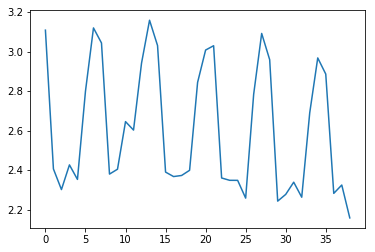

In [26]:
plt.plot(testpreds[129])

In [27]:
preddf=pd.DataFrame(testpreds,index= rrvf_data.idx_to_store(range(testpreds.shape[0]))
                    ,columns= rrvf_data.idx_to_date(range(478,478+39)))
preddf=preddf.unstack().reset_index()
preddf.columns=['date','store','transformed_visitors']
preddf['id']=preddf[['store','date']].apply(lambda u: "_".join(u.values),axis=1)
preddf['visitors']=np.expm1(preddf['transformed_visitors'])
preddf=preddf.set_index(preddf['id'])
preddf.shape

(32331, 5)

In [28]:
preddf.head()

date                 store  \
id                                                                  
air_00a91d42b08b08d9_2017-04-23  2017-04-23  air_00a91d42b08b08d9   
air_0164b9927d20bcc3_2017-04-23  2017-04-23  air_0164b9927d20bcc3   
air_0241aa3964b7f861_2017-04-23  2017-04-23  air_0241aa3964b7f861   
air_0328696196e46f18_2017-04-23  2017-04-23  air_0328696196e46f18   
air_034a3d5b40d5b1b1_2017-04-23  2017-04-23  air_034a3d5b40d5b1b1   

                                 transformed_visitors  \
id                                                      
air_00a91d42b08b08d9_2017-04-23              2.473845   
air_0164b9927d20bcc3_2017-04-23              1.730092   
air_0241aa3964b7f861_2017-04-23              2.430153   
air_0328696196e46f18_2017-04-23              2.051867   
air_034a3d5b40d5b1b1_2017-04-23              3.406894   

                                                              id   visitors  
id                                                                           
air_00a91d42b08b08d9_2017-04-23  air_00a91d42b08b08d9_2017-04-23  10.867987  
air_0164b9927d20bcc3_2017-04-23  air_0164b9927d20bcc3_2017-04-23   4.641171  
air_0241aa3964b7f861_2017-04-23  air_0241aa3964b7f861_2017-04-23  10.360619  
air_0328696196e46f18_2017-04-23  air_0328696196e46f18_2017-04-23   6.782417  
air_034a3d5b40d5b1b1_2017-04-23  air_034a3d5b40d5b1b1_2017-04-23  29.171379

In [29]:
sample=pd.read_csv("../input/sample_submission.csv")
sample.shape

(32019, 2)

In [30]:
submission=preddf[['visitors']].loc[sample['id']]
submission.shape

(32019, 1)

In [31]:
submission.to_csv("../submission/3000eb_ridge_fold{}_{}_d{}.csv.gz".format(j, EXCLUDE_HARD, PRED_DATE)
                  ,compression='gzip')